In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')

In [1]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
from matplotlib.patches import Circle
import json
from collections import Counter 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import argparse


In [5]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY
from ConceptBottleneck.CUB.dataset import load_data

In [6]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [ ]:
# parser = argparse.ArgumentParser(description="Your script description here")

# # Add command-line arguments
# parser.add_argument('--seed', type=int, default=42, help='Random seed')

# # Parse the command-line arguments
# args = parser.parse_args()

# seed = args.seed

seed = 42


In [7]:
dataset = 'dsprites_20'
noisy=False
weight_decay = 0.0004
encoder_model='small3'
optimizer = 'sgd'

In [8]:
dataset_name = dataset
data_dir = "../cem/cem/{}/preprocessed/".format(dataset_name)
data_dir

'../cem/cem/dsprites_20/preprocessed/'

In [9]:
train_data_path = os.path.join(data_dir, 'train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')
extra_data_path = '../cem/cem/dsprites/preprocessed/extra.pkl'

In [10]:
pretrained = True
freeze = False
use_aux = True
expand_dim = 0
three_class = False
use_attr = True
no_img = False
batch_size = 64
uncertain_labels = False
image_dir = 'images'
num_class_attr = 2
resampling = False

In [11]:
train_loader = load_data([train_data_path], use_attr, no_img, batch_size, uncertain_labels, image_dir=image_dir, 
                         n_class_attr=num_class_attr, resampling=resampling, path_transform=lambda path: "../cem/cem/"+path, is_training=False)
val_loader = load_data([val_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, 
                        n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)
extra_loader = load_data([extra_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, 
                        n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)

In [12]:
log_folder = get_log_folder(dataset_name,weight_decay,encoder_model,optimizer)
joint_location = "ConceptBottleneck/{}/best_model_{}.pth".format(log_folder,seed)
print(joint_location)
joint_model = torch.load(joint_location,map_location=torch.device('cpu'))
r = joint_model.eval()

ConceptBottleneck/results/dsprites_20/joint_model_small3/joint/best_model_42.pth


## Plot the Dataset

In [13]:
train_pkl = pickle.load(open(train_data_path,"rb"))
val_pkl = pickle.load(open(val_data_path,"rb"))
extra_pkl = pickle.load(open(extra_data_path,"rb"))

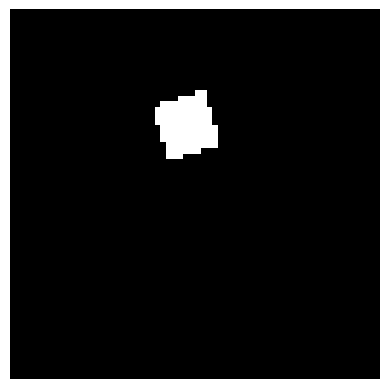

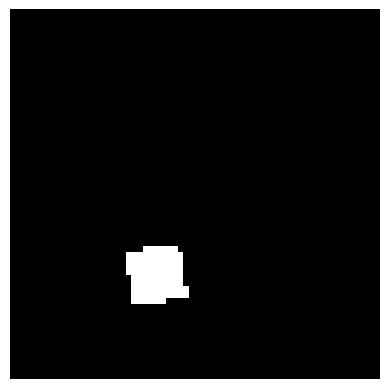

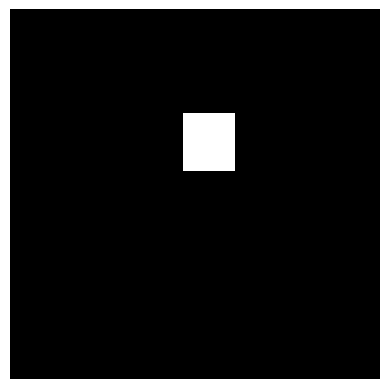

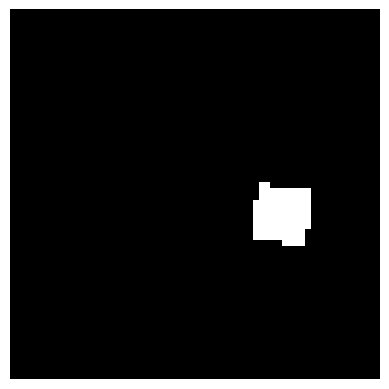

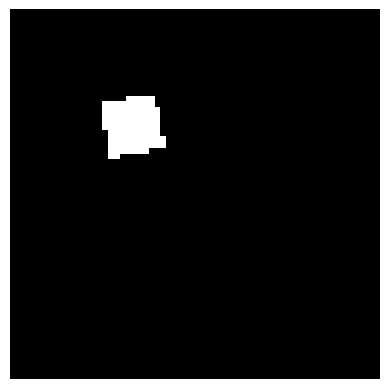

In [14]:
num_images_show = 5
for i in range(num_images_show):
    img_path = '../cem/cem/'+extra_pkl[i]['img_path']
    image = Image.open(img_path)
    image_array = np.array(image)
    plt.figure()
    plt.imshow(image_array)
    plt.axis('off') 

In [15]:
extra_images, extra_y, extra_c = unroll_data(extra_loader)

In [17]:
accuracy = get_accuracy(joint_model,run_joint_model,train_loader), get_accuracy(joint_model,run_joint_model,val_loader)

In [16]:
concept_accuracy = get_concept_accuracy_by_concept(joint_model,run_joint_model,train_loader,sigmoid=True)

## Run Model over all Concept Combinations

In [16]:
_, extra_predictions = run_joint_model(joint_model,extra_images)
extra_predictions = extra_predictions.T
extra_predictions = torch.nn.Sigmoid()(extra_predictions)

In [17]:
attributes_as_matrix = np.array([i['attribute_label'] for i in extra_pkl])

In [18]:
concept_names = [
    "is_white",
    "is_square",
    "is_ellipse",
    "is_heart",
    "is_scale_0.5",
    "is_scale_0.6",
    "is_scale_0.7",
    "is_scale_0.8",
    "is_scale_0.9",
    "is_scale_1",
    "is_orientation_0",
    "is_orientation_90",
    "is_orientation_180",
    "is_orientation_270",
    "is_x_0",
    "is_x_16",
    "is_y_0",
    "is_y_16",
] 

In [19]:
def get_results(extra_predictions,attributes_as_matrix):
    results = {}
    num_concepts = extra_predictions.shape[1]
    for i in range(num_concepts):
        data_points_with_concept = np.where(attributes_as_matrix[:, i] == 1)[0]
        data_points_without_concept = np.where(attributes_as_matrix[:, i] == 0)[0]

        min_with_concept = torch.min(extra_predictions[data_points_with_concept,i]).item()
        max_with_concept = torch.max(extra_predictions[data_points_with_concept,i]).item()
        argmin_with_concept = data_points_with_concept[torch.argmin(extra_predictions[data_points_with_concept,i]).item()].item()
        argmax_with_concept = data_points_with_concept[torch.argmax(extra_predictions[data_points_with_concept,i]).item()].item()
        freq_with_concept_adversarial = (len([p for p in data_points_with_concept if extra_predictions[p, i] < 0.75]),len(data_points_with_concept))

        if len(data_points_without_concept) == 0:
            min_without_concept = -1
            max_without_concept = -1

            argmin_without_concept = -1
            argmax_without_concept = -1
        else:
            min_without_concept = torch.min(extra_predictions[data_points_without_concept,i]).item()
            max_without_concept = torch.max(extra_predictions[data_points_without_concept,i]).item()

            argmin_without_concept = data_points_without_concept[torch.argmin(extra_predictions[data_points_without_concept,i]).item()].item()
            argmax_without_concept = data_points_without_concept[torch.argmax(extra_predictions[data_points_without_concept,i]).item()].item()

        results[concept_names[i]] = {
            'min_with_concept': min_with_concept, 
            'max_with_concept': max_with_concept, 
            'min_without_concept': min_without_concept, 
            'max_without_concept': max_without_concept,
            'freq_with_concept_adversarial': freq_with_concept_adversarial,
            'argmin_with_concept': argmin_with_concept, 
            'argmax_with_concept': argmax_with_concept, 
            'argmin_without_concept': argmin_without_concept, 
            'argmax_without_concept': argmax_without_concept,
        }

    return results

In [20]:
def get_results_dataset(dataset_name):
    log_folder = get_log_folder(dataset_name,weight_decay,encoder_model,optimizer)
    joint_location = "ConceptBottleneck/{}/best_model_{}.pth".format(log_folder,seed)
    model = torch.load(joint_location,map_location=torch.device('cpu'))
    model.eval()

    _, extra_predictions_dataset = run_joint_model(model,extra_images)
    extra_predictions_dataset = extra_predictions_dataset.T
    extra_predictions_dataset = torch.nn.Sigmoid()(extra_predictions_dataset)

    return get_results(extra_predictions_dataset,attributes_as_matrix)

In [52]:
dsprites_20_results = {
    'accuracy': accuracy[0].item(), 
    'concept_accuracy': concept_accuracy.detach().numpy().tolist() 
}

json.dump(dsprites_20_results,open('results/dsprites/dsprites_20_accuracy_{}.json'.format(seed),'w'))

In [21]:
results = get_results(extra_predictions,attributes_as_matrix)
json.dump(results,open('results/dsprites/dsprites_20_results_{}.json'.format(seed),'w'))

In [54]:
results_5 = get_results_dataset('dsprites_5')
results_10 = get_results_dataset('dsprites')
results_15 = get_results_dataset('dsprites_15')

In [55]:
json.dump(results_5,open('results/dsprites/dsprites_5_results_{}.json'.format(seed),'w'))
json.dump(results_10,open('results/dsprites/dsprites_10_results_{}.json'.format(seed),'w'))
json.dump(results_15,open('results/dsprites/dsprites_15_results_{}.json'.format(seed),'w'))

In [22]:
present_concept_combo = list(set([list_to_string(i['attribute_label']) for i in train_pkl]))
all_predictions = [list_to_string([int(i) for i in np.round(j.detach().numpy())]) for j in extra_predictions]
correct_answers = [list_to_string(i) for i in attributes_as_matrix]

In [105]:
predictions_20 = {
    'our_predictions': all_predictions, 
    'ground_truths': correct_answers, 
    'train_concepts': present_concept_combo, 
    'predictions_raw': extra_predictions.detach().numpy().tolist()
}

json.dump(predictions_20,open('results/dsprites/dsprites_20_predictions_{}.json'.format(seed),'w'))

In [23]:
images_as_numpy = extra_images.detach().numpy() 
images_reshaped = images_as_numpy.reshape(288, -1)
pca = PCA(n_components=2)
images_pca = pca.fit_transform(images_reshaped)

In [24]:
image_similarity = np.zeros((len(extra_images),len(extra_images)))
for i in range(len(extra_images)):
    for j in range(len(extra_images)):
        image_similarity[i][j] = torch.norm(extra_images[i]-extra_images[j]).item() 

In [31]:
difficulty_of_prediction = []

for i in range(len(concept_names)):
    if i == 0:
        difficulty_of_prediction.append(1)
        continue

    X = images_pca 
    y = [int(a[i]) for a in correct_answers]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    svm_classifier = SVC(kernel='linear')  # You can choose different kernels as needed
    svm_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = svm_classifier.predict(X_test)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    difficulty_of_prediction.append(accuracy)


In [32]:
json.dump({
    'pca_images': images_pca.tolist(), 
    'image_similarities': image_similarity.tolist(), 
    'svm_accuracies': difficulty_of_prediction
},open('results/dsprites/pca_images_{}.json'.format(seed),'w'))

## Summary Statistics

In [98]:
def adversarial_rate(r):
    return np.sum([r[i]['freq_with_concept_adversarial'][0] for i in r])/np.sum([r[i]['freq_with_concept_adversarial'][1] for i in r])

In [99]:
adversarial_rates = {
    'dsprites_5': adversarial_rate(results_5), 
    'dsprites_10': adversarial_rate(results_10), 
    'dsprites_15': adversarial_rate(results_15), 
    'dsprites_20': adversarial_rate(results), 
}
adversarial_rates

{'dsprites_5': 0.4195601851851852,
 'dsprites_10': 0.36747685185185186,
 'dsprites_15': 0.3472222222222222,
 'dsprites_20': 0.3420138888888889}

In [100]:
overall_accuracy = len([i for i in range(len(correct_answers)) if correct_answers[i] == all_predictions[i]])/len(all_predictions)

In [101]:
frequency_train_predicted = len([i for i in all_predictions if i in present_concept_combo])/len(all_predictions)
frequency_train_predicted

0.28125

In [102]:
adversarial_rates_concept = {}
for i in results:
    adversarial_rates_concept[i] = results[i]['freq_with_concept_adversarial'][0]/results[i]['freq_with_concept_adversarial'][1]
adversarial_rates_concept

{'is_white': 0.0,
 'is_square': 0.65625,
 'is_ellipse': 0.5729166666666666,
 'is_heart': 0.3541666666666667,
 'is_scale_0.5': 0.9166666666666666,
 'is_scale_0.6': 0.8125,
 'is_scale_0.7': 0.6875,
 'is_scale_0.8': 0.8541666666666666,
 'is_scale_0.9': 0.9375,
 'is_scale_1': 0.25,
 'is_orientation_0': 0.8055555555555556,
 'is_orientation_90': 0.5555555555555556,
 'is_orientation_180': 0.7083333333333334,
 'is_orientation_270': 0.8472222222222222,
 'is_x_0': 0.027777777777777776,
 'is_x_16': 0.013888888888888888,
 'is_y_0': 0.020833333333333332,
 'is_y_16': 0.041666666666666664}

In [104]:
summary_stats = {
    'adversarial_rates': adversarial_rates, 
    'frequency_train_predicted': frequency_train_predicted, 
    'overall_accuracy': overall_accuracy, 
    'adversarial_rates_concept': adversarial_rates_concept, 
}

json.dump(summary_stats, open('results/dsprites/summary_stats_{}.json'.format(seed),'w'))